In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import resample
from scipy.optimize import minimize
import torch
import deepwave
import cv2

import deepinvhessian.fwi as fwi
from deepinvhessian.utilities import *
import deepinvhessian.fwi_lbfgs_volve as fwi_lbfgs_volve

In [2]:
set_seed(14)

# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Prepare data

In [3]:
# Velocity model
inputvolve = np.load('../data/Velocities.npz')
velback = inputvolve["vback"]
print(velback.shape)
x = inputvolve["x"]
z = inputvolve["z"]
r = inputvolve["recs"].T

(900, 1290)


In [4]:
# Remove water layer and create the initial model by smoothing the velocity model velback
velback_no_water = np.copy(velback)
velback_no_water[velback_no_water==1480] = 1800
model_init = gaussian_filter(velback_no_water, sigma=60)
model_init = cv2.resize(model_init, (516, 360))
# model_init = torch.tensor(model_init)

In [5]:
# MDD data
fmdd = np.load('../data/mdd_volvereal_multimasked_iter40_batch32_all.npz')

t = fmdd['t']
rmdd = fmdd['Rnsgd']
# Resample data
print(rmdd.shape)
rmdd = resample(rmdd, len(rmdd[:, 10, 10])*2)
print(rmdd.shape)
t = resample(t, len(t)*2)
print(t.shape)

(2000, 180, 180)
(4000, 180, 180)
(4000,)


In [6]:
par = {
        # model parameters
        'nx':516,   'dx':12.5,  'ox':0,
        'nz':360,   'dz':12.5,  'oz':0,
        'nr':180,   'dr':torch.tensor(r[0]),  'orec':0,  'rz':torch.tensor(r[1]),
        'num_shots':180,   'ds':torch.tensor(r[0]),  'os':0,  'sz':torch.tensor(r[1]),
        'nt':4000,  'dt':0.001,  'ot':500,
        'num_sources_per_shot': 1, 'num_receivers_per_shot': 180,
        'num_dims':2,
        'num_batches':180,
        'freq': 4,
        'dt': 0.001
}

In [7]:
exp_name = 'Exp_Volve_LBFGS'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

In [10]:
model_true = torch.tensor(velback_no_water).float()
# Create mask for the shallow part of the gradient
mask = torch.ones_like(torch.tensor(model_init), dtype=torch.float32)
mask[:25] = 0

## Max frequency : 4 Hz

In [12]:
# 4Hz
model = model_init.copy().ravel()
wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_4Hz.npz')['wav']
time_shift = wavelet.argmax()
wav_scaling = 0.0002
params = fwi.FWIParams(par, wav_scaling*torch.tensor(wavelet), 'volve')
source_amplitudes = params.create_wavelet(wav_scaling*torch.tensor(wavelet))
# Create a mask for the direct arrivals
masks_d = params.create_masks(window_size = 600, v_direct = 1800, ot=1000)
masks_d = torch.tensor(masks_d).float().to(device)
observed_data = fwi.process_data(params, rmdd, pd=20, fn=4, time_shift=time_shift, window_size = 600, v_direct = 1800, 
                                more_near_offset_mute=None).to(device)
# Initialize the FWI class
fwi_l = fwi_lbfgs_volve.FWI_LBFGS(-observed_data, source_amplitudes, params.s_cor, params.r_cor, params.dx, params.dt, 
                          params.num_batches, model_init.shape, mask.to(device), scaling=1., mask_d=masks_d, device=device)
# Perform the forward pass
fwi_l.forward(model, scipy=True)
# Compute the gradient
first_res_4Hz, grad = fwi_l.grad(model, scipy=True)
# Compute the gradient scaling
fwi_l.scaling = (grad * mask.numpy().ravel()).max()
scaling_4Hz = fwi_l.scaling
# print(fwi_l.scaling)

Func
Loss 1.7965126734604143e-11
Grad
1.0


In [14]:
# Create functions to run FWI with Scipy optimization
fun = lambda x: fwi_l.forward(x, scipy=True)
grad = lambda x: fwi_l.grad(x, scipy=True)[-1]
callback = lambda x: fwi_l.callback(x, model_true, MSSIM, data_residual, nWE)

In [15]:
MSSIM, data_residual, nWE = [], [], []
model0 = torch.tensor(model).float()
# model2 = nl.x.reshape(360, par['nx']).copy()
# model2 = torch.tensor(model2).float().ravel()
# Run FWI using Scipy L-BFGS
nl = minimize(fun, model0, jac=grad,
              method='L-BFGS-B', 
              callback=callback,
              options=dict(maxiter=20,),
             )
nWE_4Hz = np.array(nWE)
data_residual_4Hz = np.array(data_residual)
model_4Hz = nl.x.reshape(par['nz'], par['nx']).copy()

Func
Loss 14819780.864099417
Grad
1.212239701743786e-18
Func
Loss 14819615.364788128
Grad
1.212239701743786e-18
Func
Loss 14818942.746788038
Grad
1.212239701743786e-18
Func
Loss 14816224.157736443
Grad
1.212239701743786e-18
Func
Loss 14805411.290111287
Grad
1.212239701743786e-18
Func
Loss 14762762.34062816
Grad
1.212239701743786e-18
Func
Loss 14602036.203434253
Grad
1.212239701743786e-18
Func
Loss 14602036.203434253
Func
Loss 13443250.957624502
Grad
1.212239701743786e-18
Func
Loss 13443250.957624502
Func
Loss 13063177.071399907
Grad
1.212239701743786e-18
Func
Loss 13063177.071399907
Func
Loss 12641573.543080416
Grad
1.212239701743786e-18
Func
Loss 12641573.543080416
Func
Loss 12395457.855395012
Grad
1.212239701743786e-18
Func
Loss 12395457.855395012
Func
Loss 12169105.444579069
Grad
1.212239701743786e-18
Func
Loss 12169105.444579069
Func
Loss 11821090.259620747
Grad
1.212239701743786e-18
Func
Loss 11821090.259620747
Func
Loss 11568119.165296195
Grad
1.212239701743786e-18
Func
Loss 1156

## Max frequency : 7 Hz

In [16]:
model = model_4Hz.copy().ravel()
wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_7Hz.npz')['wav']
params = fwi.FWIParams(par, wav_scaling*torch.tensor(wavelet), 'volve')
source_amplitudes = params.create_wavelet(wav_scaling*torch.tensor(wavelet))
observed_data = fwi.process_data(params, rmdd, pd=20, fn=7, time_shift=time_shift, window_size = 600, v_direct = 1800, 
                                more_near_offset_mute=None).to(device)
# Initialize the FWI class
fwi_l = fwi_lbfgs_volve.FWI_LBFGS(-observed_data, source_amplitudes, params.s_cor, params.r_cor, params.dx, params.dt, 
                          params.num_batches, model_init.shape, mask.to(device), scaling=1., mask_d=masks_d, device=device)
# Perform the forward pass
fwi_l.forward(model, scipy=True)
# Compute the gradient
first_res_7Hz, grad = fwi_l.grad(model, scipy=True)
# Compute the gradient scaling
fwi_l.scaling = (grad * mask.numpy().ravel()).max()
scaling_7Hz = fwi_l.scaling
# print(fwi_l.scaling)

Func
Loss 1.308590535844395e-09
Grad
1.0


In [17]:
# Create functions to run FWI with Scipy optimization
fun = lambda x: fwi_l.forward(x, scipy=True)
grad = lambda x: fwi_l.grad(x, scipy=True)[-1]
callback = lambda x: fwi_l.callback(x, model_true, MSSIM, data_residual, nWE)

In [18]:
MSSIM, data_residual, nWE = [], [], []
model0 = torch.tensor(model_4Hz).float().ravel()
# model2 = nl.x.reshape(360, 516).copy()
# model2 = torch.tensor(model2).float().ravel()
# Run FWI using Scipy L-BFGS
nl = minimize(fun, model0, jac=grad,
              method='L-BFGS-B', 
              callback=callback,
              options=dict(maxiter=20,),
             )
nWE_7Hz = np.array(nWE)
data_residual_7Hz = np.array(data_residual)
model_7Hz = nl.x.reshape(par['nz'], par['nx']).copy()

Func
Loss 127555544.18469076
Grad
1.025898595163888e-17
Func
Loss 127555222.18920362
Grad
1.025898595163888e-17
Func
Loss 127553945.72672072
Grad
1.025898595163888e-17
Func
Loss 127548834.5292207
Grad
1.025898595163888e-17
Func
Loss 127528447.16745605
Grad
1.025898595163888e-17
Func
Loss 127447698.8411112
Grad
1.025898595163888e-17
Func
Loss 127137665.0826023
Grad
1.025898595163888e-17
Func
Loss 127137665.0826023
Func
Loss 124095345.65640955
Grad
1.025898595163888e-17
Func
Loss 124095345.65640955
Func
Loss 123057977.54698451
Grad
1.025898595163888e-17
Func
Loss 123057977.54698451
Func
Loss 122591332.99562752
Grad
1.025898595163888e-17
Func
Loss 122591332.99562752
Func
Loss 121737495.88833925
Grad
1.025898595163888e-17
Func
Loss 121737495.88833925
Func
Loss 121341073.40807216
Grad
1.025898595163888e-17
Func
Loss 121341073.40807216
Func
Loss 120193439.91612172
Grad
1.025898595163888e-17
Func
Loss 120193439.91612172
Func
Loss 119557970.02799581
Grad
1.025898595163888e-17
Func
Loss 1195579

## Max frequency : 10 Hz

In [19]:
model = model_7Hz.copy().ravel()
wavelet = np.load('estimated_wavelets/Volve/Estimated_wav_10Hz.npz')['wav']
params = fwi.FWIParams(par, wav_scaling*torch.tensor(wavelet), 'volve')
source_amplitudes = params.create_wavelet(wav_scaling*torch.tensor(wavelet))
observed_data = fwi.process_data(params, rmdd, pd=20, fn=10, time_shift=time_shift, window_size = 600, v_direct = 1800, 
                                more_near_offset_mute=None).to(device)
# Initialize the FWI class
fwi_l = fwi_lbfgs_volve.FWI_LBFGS(-observed_data, source_amplitudes, params.s_cor, params.r_cor, params.dx, params.dt, 
                          params.num_batches, model_init.shape, mask.to(device), scaling=1., mask_d=masks_d, device=device)
# Perform the forward pass
fwi_l.forward(model, scipy=True)
# Compute the gradient
first_res_10Hz, grad = fwi_l.grad(model, scipy=True)
# Compute the gradient scaling
fwi_l.scaling = (grad * mask.numpy().ravel()).max()
scaling_10Hz = fwi_l.scaling
# print(fwi_l.scaling)

Func
Loss 3.730714458714812e-09
Grad
1.0


In [20]:
# Create functions to run FWI with Scipy optimization
fun = lambda x: fwi_l.forward(x, scipy=True)
grad = lambda x: fwi_l.grad(x, scipy=True)[-1]
callback = lambda x: fwi_l.callback(x, model_true, MSSIM, data_residual, nWE)

In [21]:
MSSIM, data_residual, nWE = [], [], []
model0 = torch.tensor(model_7Hz).float().ravel()
# model2 = nl.x.reshape(360, 516).copy()
# model2 = torch.tensor(model2).float().ravel()
# Run FWI using Scipy L-BFGS
nl = minimize(fun, model0, jac=grad,
              method='L-BFGS-B', 
              callback=callback,
              options=dict(maxiter=20,),
             )
nWE_10Hz = np.array(nWE)
data_residual_10Hz = np.array(data_residual)
model_10Hz = nl.x.reshape(par['nz'], par['nx']).copy()

Func
Loss 71702378.31766883
Grad
5.2030553884647e-17
Func
Loss 71702236.68732327
Grad
5.2030553884647e-17
Func
Loss 71701670.99945298
Grad
5.2030553884647e-17
Func
Loss 71699424.08469832
Grad
5.2030553884647e-17
Func
Loss 71690672.35956393
Grad
5.2030553884647e-17
Func
Loss 71659546.40722048
Grad
5.2030553884647e-17
Func
Loss 71659546.40722048
Func
Loss 71554353.20198075
Grad
5.2030553884647e-17
Func
Loss 71554353.20198075
Func
Loss 71498065.80857639
Grad
5.2030553884647e-17
Func
Loss 71498065.80857639
Func
Loss 71340770.50666907
Grad
5.2030553884647e-17
Func
Loss 71340770.50666907
Func
Loss 71240034.65645702
Grad
5.2030553884647e-17
Func
Loss 71240034.65645702
Func
Loss 71017176.50713076
Grad
5.2030553884647e-17
Func
Loss 71017176.50713076
Func
Loss 70861006.64635915
Grad
5.2030553884647e-17
Func
Loss 70861006.64635915
Func
Loss 70815565.71023734
Grad
5.2030553884647e-17
Func
Loss 70815565.71023734
Func
Loss 70782065.39916657
Grad
5.2030553884647e-17
Func
Loss 70782065.39916657
Func
L

## Plot results

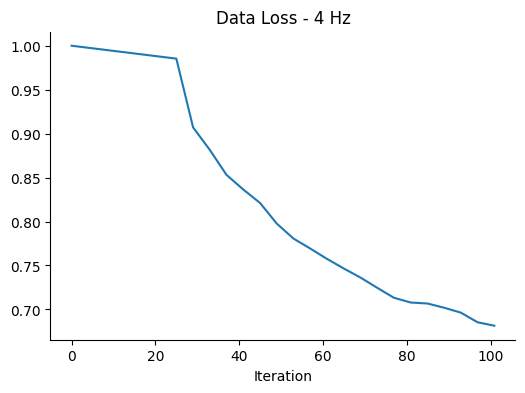

In [27]:
# Descale the data residual
data_res_4Hz = data_residual_4Hz * scaling_4Hz / params.num_shots
# Include the first loss value
data_res_4Hz = np.concatenate([np.array([first_res_4Hz/params.num_shots]), data_res_4Hz], axis=0)
# Plot the data loss per number of wave equation solved 
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.concatenate([[0], nWE_4Hz/params.num_shots]), data_res_4Hz/data_res_4Hz.max())
ax.set_title('Data Loss - 4 Hz')
ax.set_xlabel('Iteration')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

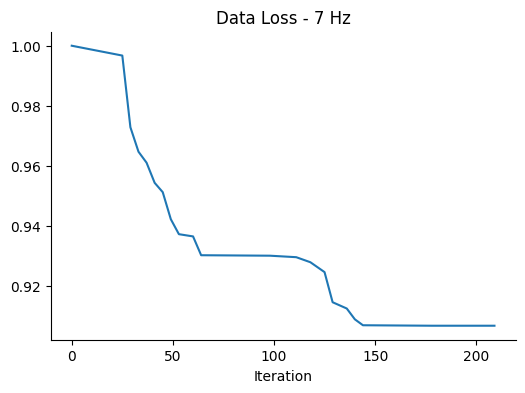

In [29]:
# Descale the data residual
data_res_7Hz = data_residual_7Hz * scaling_7Hz / params.num_shots
# Include the first loss value
data_res_7Hz = np.concatenate([np.array([first_res_7Hz/params.num_shots]), data_res_7Hz], axis=0)
# Plot the data loss per number of wave equation solved 
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.concatenate([[0], nWE_7Hz/params.num_shots]), data_res_7Hz/data_res_7Hz.max())
ax.set_title('Data Loss - 7 Hz')
ax.set_xlabel('Iteration')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

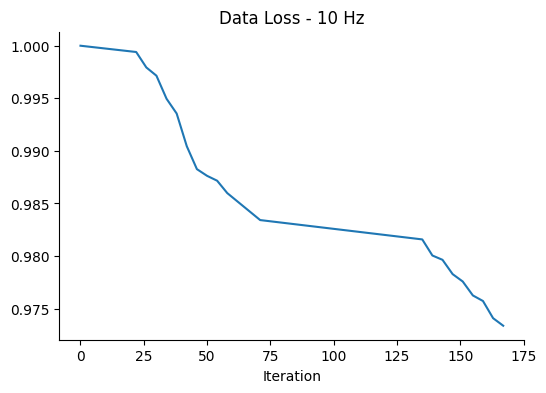

In [30]:
# Descale the data residual
data_res_10Hz = data_residual_10Hz * scaling_10Hz / params.num_shots
# Include the first loss value
data_res_10Hz = np.concatenate([np.array([first_res_10Hz/params.num_shots]), data_res_10Hz], axis=0)
# Plot the data loss per number of wave equation solved 
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.concatenate([[0], nWE_10Hz/params.num_shots]), data_res_10Hz/data_res_10Hz.max())
ax.set_title('Data Loss - 10 Hz')
ax.set_xlabel('Iteration')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

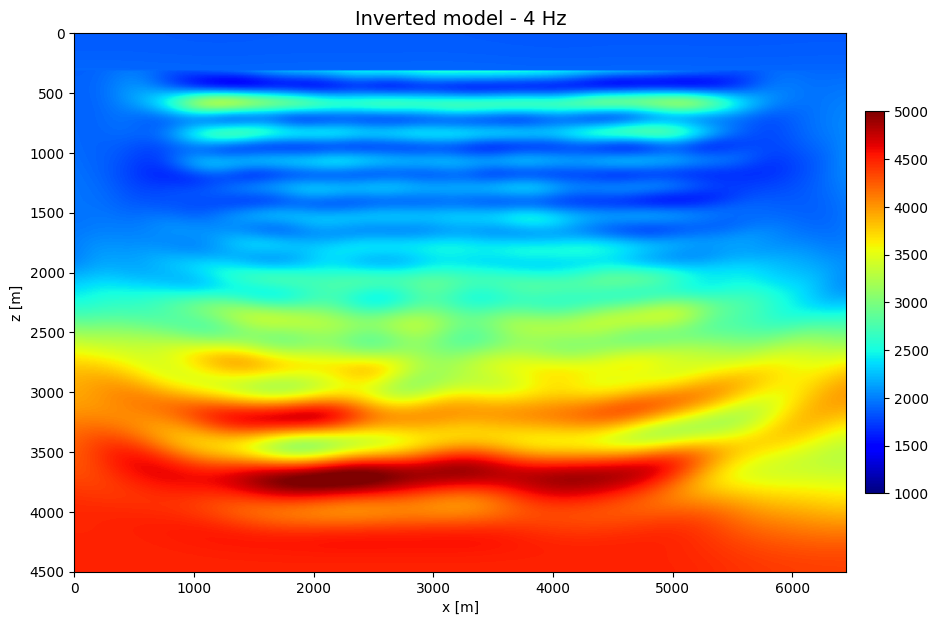

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
im1 = axs.imshow(model_4Hz, cmap='jet', vmin=1000, vmax=5000, extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs.set_title(r'Inverted model - 4 Hz', fontsize=14)
axs.set_xlabel(r'x [m]')
axs.set_ylabel(r'z [m]')
fig.colorbar(im1, ax=axs, shrink=0.62, pad=0.02)
plt.savefig(f'{exp_name}/model_updated_4Hz', bbox_inches='tight', dpi=300)

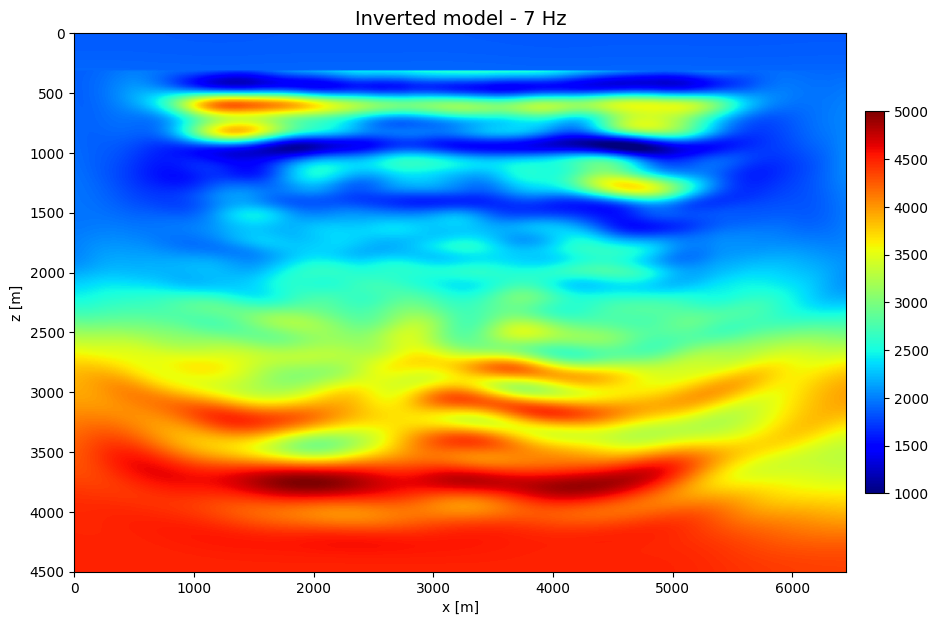

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
im1 = axs.imshow(model_7Hz, cmap='jet', vmin=1000, vmax=5000, extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs.set_title(r'Inverted model - 7 Hz', fontsize=14)
axs.set_xlabel(r'x [m]')
axs.set_ylabel(r'z [m]')
fig.colorbar(im1, ax=axs, shrink=0.62, pad=0.02)
plt.savefig(f'{exp_name}/model_updated_7Hz', bbox_inches='tight', dpi=300)

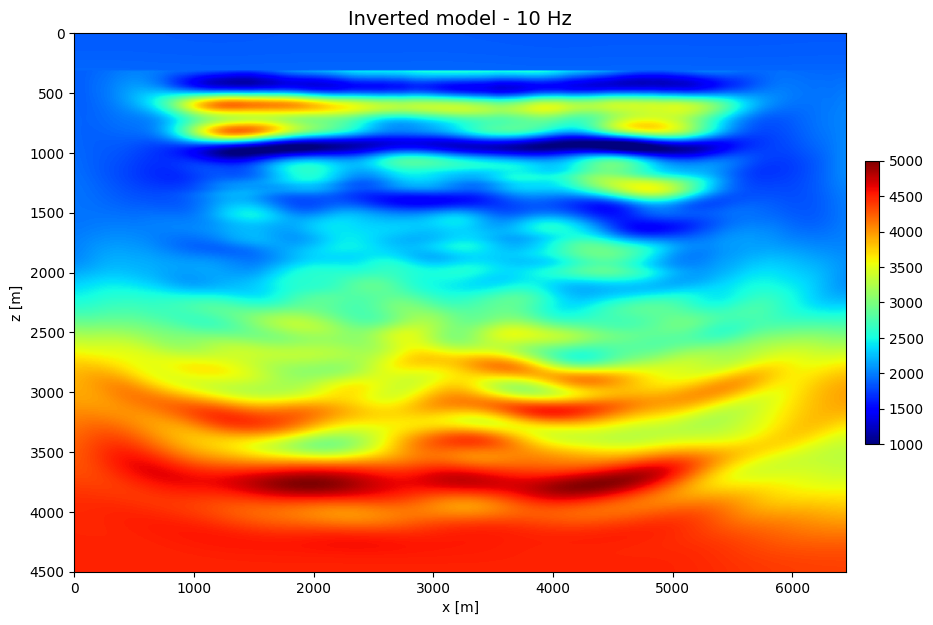

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
im1 = axs.imshow(model_10Hz, cmap='jet', vmin=1000, vmax=5000, extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs.set_title(r'Inverted model - 10 Hz', fontsize=14)
axs.set_xlabel(r'x [m]')
axs.set_ylabel(r'z [m]')
fig.colorbar(im1, ax=axs, shrink=0.46, pad=0.02)
plt.savefig(f'{exp_name}/model_updated_10Hz', bbox_inches='tight', dpi=300)

## Save results

In [38]:
np.savez(f'{exp_name}/results_4Hz', data_loss=np.array(data_res_4Hz/data_res_4Hz.max()), 
                                     nWE=np.concatenate([[0], nWE_4Hz/params.num_shots])
                                     )
np.save(f'{exp_name}/update_4Hz', model_4Hz)

In [39]:
np.savez(f'{exp_name}/results_7Hz', data_loss=np.array(data_res_7Hz/data_res_7Hz.max()), 
                                     nWE=np.concatenate([[0], nWE_7Hz/params.num_shots])
                                     )
np.save(f'{exp_name}/update_7Hz', model_7Hz)

In [37]:
np.savez(f'{exp_name}/results_10Hz', data_loss=np.array(data_res_10Hz/data_res_10Hz.max()), 
                                     nWE=np.concatenate([[0], nWE_10Hz/params.num_shots])
                                     )
np.save(f'{exp_name}/update_10Hz', model_10Hz)